In [5]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv
from IPython.display import display, Math
from numpy import unravel_index
from astropy.io import fits
from astropy.table import Table

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Quasar Systematics")

Quasar Systematics


## Import the data

### Import the quasars from Gaia in a 7° radius around M31

In [100]:
hdu_list = fits.open('ThisIsTheData/Quasars/Quasars9Deg.fits', memmap=True)
hdu_list.info()
evt_data = Table(hdu_list[1].data)
evt_data

Filename: ThisIsTheData/Quasars/Quasars9Deg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (733,)   uint8   
  1  /home/svalentin/Documents/S2/Code/Quasar/Gaia_EDR3_AGNs.csv    1 BinTableHDU     26   8087R x 7C   [D, D, E, E, E, E, E]   


RA_ICRS,DE_ICRS,pmRA,e_pmRA,pmDE,e_pmDE,pmRApmDEcor
float64,float64,float32,float32,float32,float32,float32
14.51494996076,33.18963139179,0.446,0.409,-0.131,0.271,0.0966
14.8535384333,33.30587497913,0.165,0.228,0.034,0.169,0.0883
14.78227868691,33.47892550739,0.326,0.465,0.971,0.483,0.2994
15.30408414102,33.56151961951,1.434,0.582,0.136,0.46,0.4056
15.31460375219,33.55830851971,-0.028,0.469,-0.839,0.362,0.2998
15.23190064275,33.58353519805,-0.476,0.54,-0.363,0.513,0.5005
14.94897545436,33.66806426593,-2.523,1.94,1.02,1.434,0.1529
14.98039786701,33.71975260973,-0.415,0.52,0.039,0.378,0.169
15.15954452281,33.75170057371,0.316,0.406,0.371,0.318,0.1822


In [101]:
Delta = 41.27*np.pi/180

evt_data['RA_ICRS']  = (evt_data['RA_ICRS'] - 10.68)*np.cos(Delta)
evt_data['DE_ICRS'] = (evt_data['DE_ICRS'] - 41.27)

### Import the data from the model (purely aesthetic)

In [102]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [103]:
#Reading the cvs files
x_model, y_model, z_model = OutCVSModel("model")

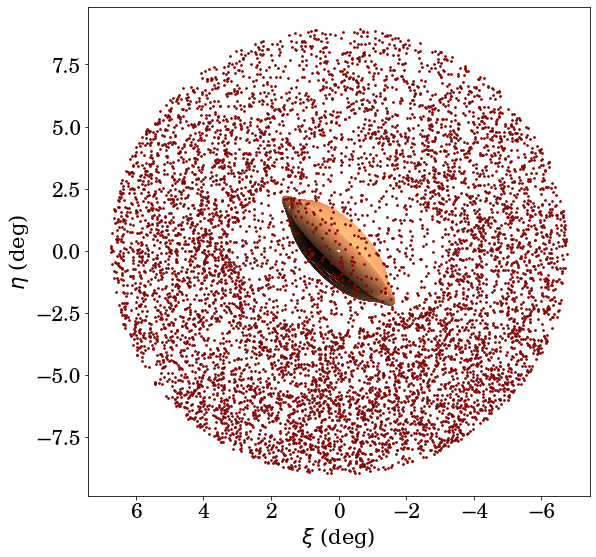

In [104]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)
plt.scatter(evt_data['RA_ICRS'], evt_data['DE_ICRS'], c='#880808', s=3)

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
#plt.xlim(-2.3, 2.3)
#plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

### Selection of the different regions

In [109]:
def ElContaminant(RA, DEC, Num): 
    #___ Description_____________________________________________________________________________________
    #Arguments:: This function basically is a simplified function than the one found from 'CleaningCuts' 
    #           It separates the space in 4 quadrant here being N(Num=1), S(Num=2), E(Num=3), W(Num=0). 
    #           RA and DEC position of objects.
    #Returns:: returns either true or false if the object is in one of the four quadrant or not
    #____________________________________________________________________________________________________
    Ra, Dec = np.array(RA), np.array(DEC)
    Result = []
    
    Sign = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
    
    PA     = 45*np.pi/180 #radians, position angle
    
    AngDia2 = 9 #degrees, inclination angle
    A     = AngDia2
    B     = AngDia2
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])
    
    for i in range(len(Ra)):
        Ell_rot = np.dot(R_rot, [Ra[i], Dec[i]])
        if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1: #Keeps every stars in the big ellipse
            if Sign[Num][0]*Ell_rot[0]*np.cos(PA) < 0 and Sign[Num][1]*Ell_rot[1]*np.sin(PA) < 0: #Linear selection along lines
                Result.append(True)
            else: 
                Result.append(False)
        else: 
            Result.append(False)

    return Result

In [113]:
def Quadrant(evt_data, Number):
    #___ Description_____________________________________________________________________________________
    #Arguments:: Astropy table in which we find RA and DEC coordinates and a number (see ElContaminant)
    #Returns:: list of the coordinates in the choosen quadrant and also the corresponding pm...
    #____________________________________________________________________________________________________
    mask = (np.array(ElContaminant(evt_data['RA_ICRS'], evt_data['DE_ICRS'], Number)) == True)
    
    return evt_data[mask]['RA_ICRS'], evt_data[mask]['DE_ICRS'], evt_data[mask]['pmRA'], evt_data[mask]['e_pmRA'], evt_data[mask]['pmDE'], evt_data[mask]['e_pmDE'], evt_data[mask]['pmRApmDEcor']

In [114]:
RaDec1 = Quadrant(evt_data, 0)
RaDec2 = Quadrant(evt_data, 1)
RaDec3 = Quadrant(evt_data, 2)
RaDec4 = Quadrant(evt_data, 3)

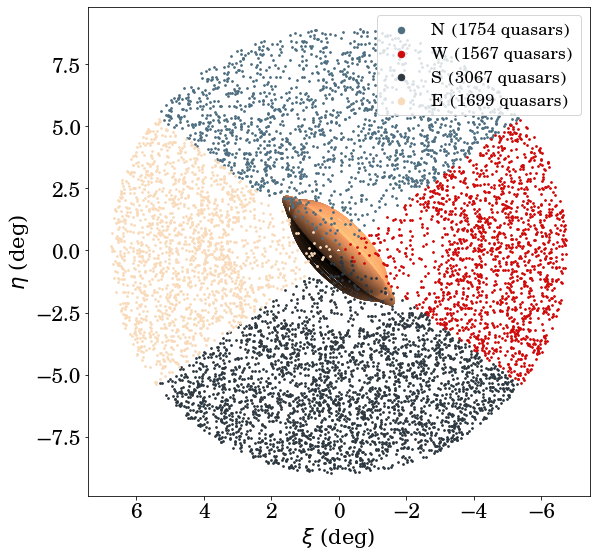

In [112]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)
plt.scatter((RaDec2[0]), (RaDec2[1]), s=3, color='#4E6E81', label=f"N ({len(RaDec2[0])} quasars)")
plt.scatter((RaDec1[0]), (RaDec1[1]), s=3, color='#CF0A0A', label=f"W ({len(RaDec1[0])} quasars)")
plt.scatter((RaDec3[0]), (RaDec3[1]), s=3, color='#2E3840', label=f"S ({len(RaDec3[0])} quasars)")
plt.scatter((RaDec4[0]), (RaDec4[1]), s=3, color='#F9DBBB', label=f"E ({len(RaDec4[0])} quasars)")
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=17)
lgnd.legendHandles[0]._sizes = [42]
lgnd.legendHandles[1]._sizes = [42]
lgnd.legendHandles[2]._sizes = [42]
lgnd.legendHandles[3]._sizes = [42]
plt.show()

### Determine the systematics in each quadrants

In [387]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData):
        self.NbModels = NbModels
        
        self.mu_ra      = GaiaData[2]
        self.mu_ra_sig  = GaiaData[3]
        self.mu_dec     = GaiaData[4]
        self.mu_dec_sig = GaiaData[5]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_ra_quasars), len(self.pm_dec_quasars)))
        for i in range(len(self.pm_dec_quasars)):
            for j in range(len(self.pm_ra_quasars)):
                for k in range(len(self.mu_ra)):
                    self.LikelihoodList[j,i] += self.LikelihoodSingleStar(k, i, j)

        self.Renormalisation()  
        
        #print(self.LikelihoodList)       
        self.OneDimGaussian()
            
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        self.pm_ra_quasars  = np.linspace(-0.050, 0.050, self.NbModels) 
        self.pm_dec_quasars = np.linspace(-0.050, 0.050, self.NbModels)
        
    def LikelihoodSingleStar(self, index_star, index_model_ra, index_model_dec):
        PreFactor = 1/(2*np.pi*self.mu_ra_sig[index_star]*self.mu_dec_sig[index_star])    
        ExpRa  = -0.5*((self.mu_ra[index_star] - self.pm_ra_quasars[index_model_ra])/(self.mu_ra_sig[index_star]))**2
        ExpDec = -0.5*((self.mu_dec[index_star] - self.pm_dec_quasars[index_model_dec])/(self.mu_dec_sig[index_star]))**2
        
        return np.log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_dec_quasars)):
            for j in range(len(self.pm_ra_quasars)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_dec_quasars[dec_max], self.pm_ra_quasars[ra_max]
        
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[ : ,i]
            self.y_gaus.append((np.sum(row)))
            
        caca = np.std(self.pm_ra_quasars*self.y_gaus)
        print(caca)
        
        widthBar = (0.1) / self.NbModels
        plt.bar(self.pm_ra_quasars, self.x_gaus, width=widthBar, align='edge', edgecolor='black')
        plt.show()
        plt.bar(self.pm_dec_quasars, self.y_gaus, width=widthBar, align='edge', edgecolor='black')
        plt.show()
             
    def PrintPlot(self):
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + r"\ \mu as/yr"))
        
        #Plot of the contours:
        plt.figure(figsize=(8, 8))
        plt.contour(self.pm_ra_quasars, self.pm_dec_quasars, self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)], 
                    #levels=[0.1, 0.5, 0.9],   
                    cmap='inferno') #values for the levels taken from the book "Numerical Recipes" and corresponding to 1, 2, 3 sigmas
        plt.scatter(self.ra_max, self.dec_max, c="#f6b515")
        plt.xticks(fontsize=15)
        plt.yticks(fontsize = 15)
        plt.xlabel(r'$\mu_{\alpha, M31}$ (mas.yr$^{-1})$', fontname = 'Serif', size = 19)
        plt.ylabel(r'$\mu_{\delta, M31}$ (mas.yr$^{-1})$', fontname = 'Serif', size = 19)
        plt.gca().invert_xaxis()
        plt.show()

0.01654581370596348


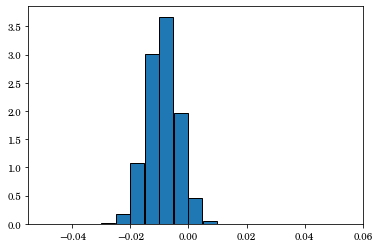

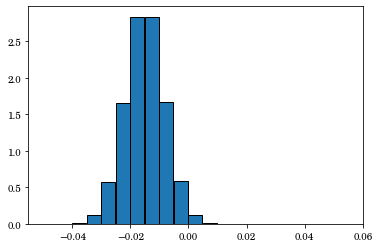

In [388]:
ObjLike = LikelihooD(21, RaDec1)
Answer  = ObjLike.Execute()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

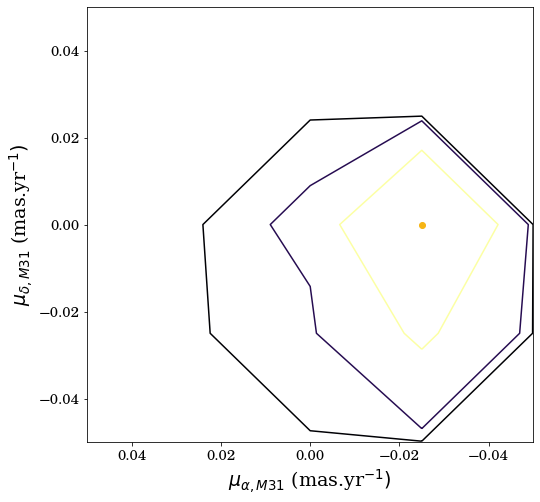

In [380]:
ObjLike.PrintPlot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

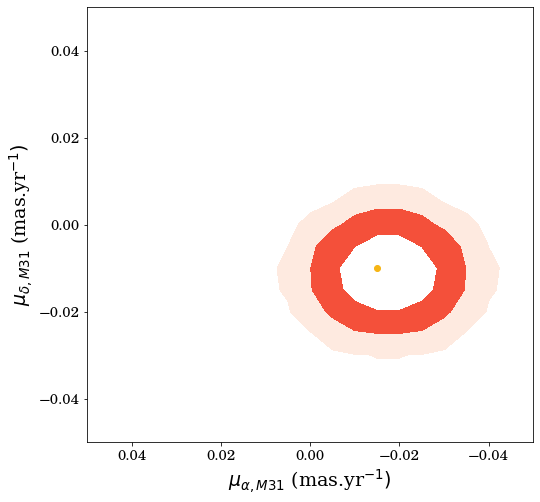

In [190]:
ObjLike.PrintPlot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

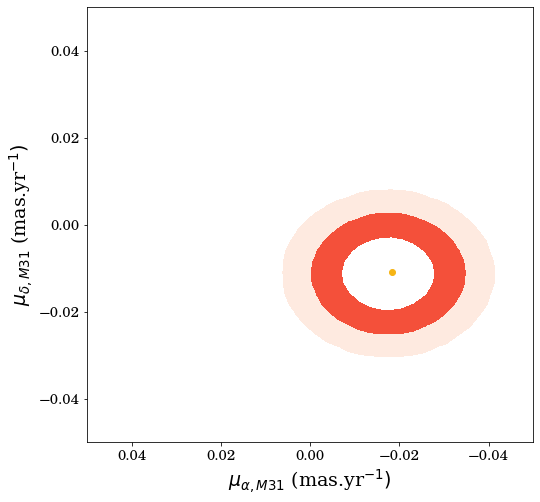

In [135]:
ObjLike = LikelihooD(42, RaDec1)
Answer  = ObjLike.Execute()
ObjLike.PrintPlot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

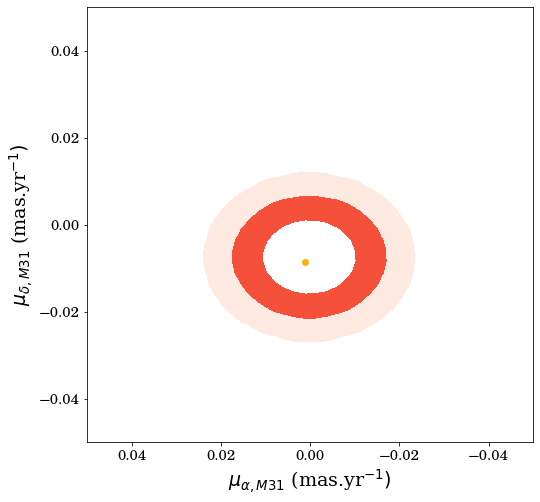

In [136]:
ObjLike = LikelihooD(42, RaDec2)
Answer  = ObjLike.Execute()
ObjLike.PrintPlot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

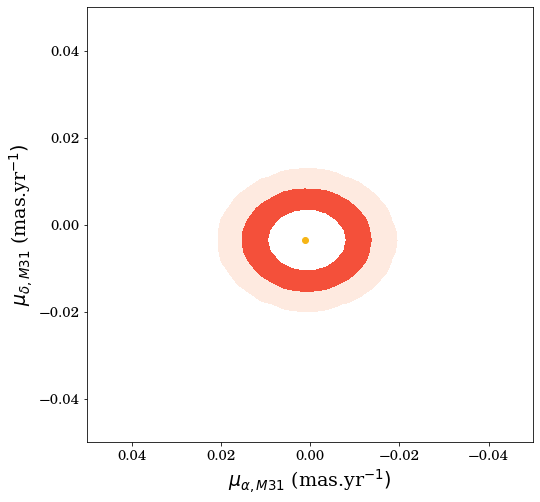

In [137]:
ObjLike = LikelihooD(42, RaDec3)
Answer  = ObjLike.Execute()
ObjLike.PrintPlot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

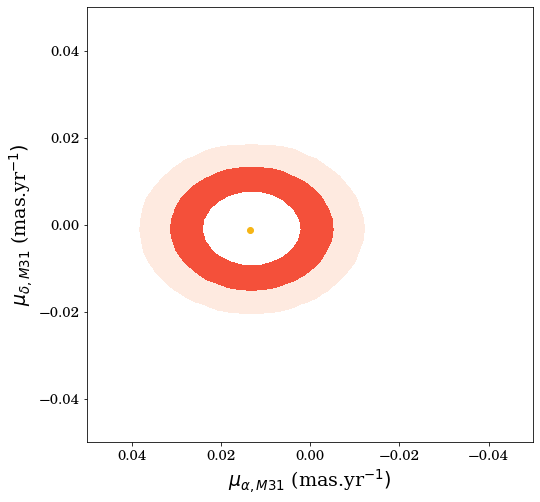

In [138]:
ObjLike = LikelihooD(42, RaDec4)
Answer  = ObjLike.Execute()
ObjLike.PrintPlot()